<a href="https://colab.research.google.com/github/SASambath69/notebooks/blob/main/Analyse_des_Messages_d'un_Groupe_WhatsApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectifs

Le présent notebook a été réalisé pour effectuer une analyse des discussions d'un groupe WhatsApp. Les informations concernant les expéditeurs seront anonymisées. Les objectifs seront les suivants :

*    A quel moment de la journée et quel jour de la semaine il y a le plus de messages ?
*    Quelles sont les contributions des membres du groupe (classement par nombre de messages envoyés) ?
*    Quels sont les 20 mots les plus utilisés (au global, puis par les 5 personnes qui envoient le plus de messages) ?
*    Quels sont les emojis les plus présents ?

# Import des Librairies

Petites précisions sur quelques librairies utilisées :

*    nltk : pour l'analyse des mots contenus dans les messages
*    string : servira pour retirer les ponctuations lors de l'analyse des mots
*    emoji : pour l'analyse des emojis les plus utilsés
*    InteractiveShell : pour afficher tous les outputs d'un bloc de code, et ne pas se limiter au dernier output
*    drive : pour me connecter à mon Google Drive et récupérer le fichier txt correspondant à la sauvegarde de la discussion WhatsApp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('popular')
import string
!pip install emoji
import emoji
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Import et Retraitement du fichier contenant les discussions

Par défaut, les discussions vont être retranscris dans un DataFrame à 1 colonne. Les retraitements et travaux seront les suivants :

1.    Identification des lignes qui correspondent à des suites de messages. En effet, selon la longueur des messages, ceux-ci peuvent apparaître sur plusieurs lignes du DataFrame. L'objectif est ainsi de les repérer selon différents moyens (longueur du texte inférieur à un certain nombre ou absence de date dans les 1ers caractères du message) puis de les replacer à la suite des messages dont ils correspondent
2.    Création d'une colonne contenant la date et heure de l'envoi du message
3.    Création d'une colonne contenant le nom de l'expéditeur et anonymisation
4.    Création de 2 colonnes correspondant au jour de la semaine (de 1 à 7) et à l'heure de la journée (de 0 à 23), puis pivot table pour afficher le nombre de messages envoyés par heure de la jour et par jour de la semaine
5.    Création d'une colonne contenant le message
6.    Identification des mots les plus utilisés (ajout de certains mots, expressions, caractères à la liste des stopwords). Pour les messages contenant des médias, ceux-ci apparaissent avec la mention "<Médias omis>". Je décide de ne pas en tenir compte
7.    Identification des mots les plus utilisés par les 5 personnes qui envoient le plus de message
8.    Identification des emojis les plus utilisés

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Discussion WhatsApp.txt', delimiter = "\t", header = None, names = ['text'])

# ------------------------------ Identification des lignes correspondant à des suites de message et replacement de ces derniers à la suite des messages auxquels ils appartiennent

df['follow_message'] = df['text'].apply(lambda x: True if len(x) < 10 else (True if x[2] != '/' else False))
df['text_def'] = df['text']
for i in range(len(df['text'])):
  if i != len(df['text'])-1 and df['follow_message'][i] == False and df['follow_message'][i+1] == False:
    pass
  elif df['follow_message'][i] == True:
    start = i
    while df['follow_message'][start] == True:
      df['text_def'][i-1] = df['text_def'][i-1] + ' ' + df['text_def'][start]
      start += 1

df = df.loc[df['follow_message'] == False].drop(columns=['text','follow_message'])

# ------------------------------ Extraction des dates et heures

df[['datetime_str','no_date']] = df["text_def"].str.split(' - ', 1, expand=True)
df['datetime_str'] = df['datetime_str'].str.replace(' à', '')
df['datetime_str'] = pd.to_datetime(df['datetime_str'])

# ------------------------------ Extraction des expéditeurs

df = df.loc[df['no_date'].str.contains(':')==True]
df[['sender','text_message']] = df['no_date'].str.split(': ', 1, expand=True)

# ------------------------------ Anonymisation

senders = list(df['sender'].unique())
anonyme = []
for i in range(len(df['sender'].unique())):
  anonyme.append('sender_{}'.format(i+1))
df['sender'] = df['sender'].replace(senders, anonyme)

# ------------------------------ Création de colonnes "day_of_week" et "hour_of_day" pour le Heatmap

df['day_of_week'] = df['datetime_str'].dt.dayofweek + 1
df['hour_of_day'] = df['datetime_str'].dt.hour
heatmap_df = df.pivot_table(index='day_of_week', columns='hour_of_day', values='text_message', aggfunc='count')

# ------------------------------ Repérer les mots les plus utilisés

stop_words = list(stopwords.words('french'))
stop_words.extend(['a','’','je','ça','ca','c','j','et','...'])

all_words = ''

# Certains messages correspondent en réalité à des médias et sont inscrits "<Médias omis>". On n'en tient pas compte pour la suite
for i in df['text_message'].loc[df['text_message'].str.lower().str.contains('médias omis')==False]:
  all_words = all_words + ' ' + i

df_words = pd.DataFrame({'words' : word_tokenize(all_words)})
df_words['no_stop_words'] = df_words['words'].apply(lambda x: x.lower() if x.lower() not in stop_words and x.lower() not in list(string.punctuation) else np.NaN)

df_top_words = pd.DataFrame({'words' : list(df_words['no_stop_words'].value_counts().head(20).index),
                                  'count' : list(df_words['no_stop_words'].value_counts().head(20).values)})

# ------------------------------ Mots les plus utilisés par expéditeur (top 5 des expéditeurs)

df_by_sender = pd.DataFrame()

for i in range(5):
  sender = df['sender'].value_counts().head(5).index[i]
  df_sender = df.loc[df['sender'] == sender].loc[df['text_message'].str.lower().str.contains('médias omis')==False]
  all_words_sender = ''
  for j in df_sender['text_message']:
    all_words_sender = all_words_sender + ' ' + j
  df_words_sender = pd.DataFrame({'sender' : sender, 'words' : word_tokenize(all_words_sender)})
  df_words_sender['no_stop_words'] = df_words_sender['words'].apply(lambda x: x.lower() if x.lower() not in stop_words and x.lower() not in list(string.punctuation) else np.NaN)
  df_words_sender_top = pd.DataFrame({'sender' : sender, 'words' : list(df_words_sender['no_stop_words'].value_counts().head(20).index), 'count' : list(df_words_sender['no_stop_words'].value_counts().head(20).values)})

  df_by_sender = pd.concat([df_by_sender, df_words_sender_top], axis = 0)

# ------------------------------ Top 10 des emojis

df_words['emoji'] = df_words['no_stop_words'].apply(lambda x: x if x in emoji.UNICODE_EMOJI and x != '\U0001f3fc' else np.NaN)

df_top_emoji = pd.DataFrame({'emoji' : list(df_words['emoji'].value_counts().head(10).index), 'count' : list(df_words['emoji'].value_counts().head(10).values)})

# A quel moment de la journée et quel jour de la semaine il y a le plus de messages ?

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Day of Week')

Text(0.5, 1.0, 'Nombre de messages envoyés par heure de la journée et par jour de la semaine')

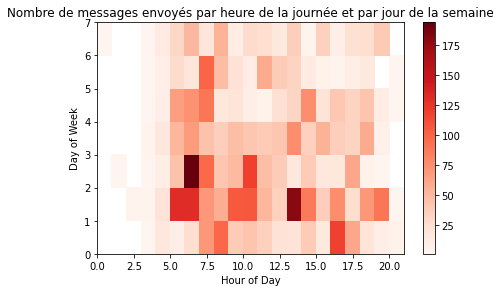

In [ ]:
# Heatmap
plt.pcolor(heatmap_df, cmap='Reds')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.colorbar()
plt.tight_layout()
plt.title('Nombre de messages envoyés par heure de la journée et par jour de la semaine')
plt.show()

Les moments où les messages sont les plus envoyés sont :
*    en début de journée (entre 5h et 8h) et début d'après-midi (vers 13h)
*    plutôt en début de semaine (Mardi et Mercredi)

# Quelles sont les contributions des membres du groupe (classement par nombre de messages envoyés) ?

In [ ]:
# Histogram
fig = px.histogram(data_frame=df, x='sender').update_xaxes(categoryorder='total descending')
fig.update_layout(title = 'Contribution des membres', title_x = 0.5)

Un membre particulièrement très actif par rapport aux autres

# Quels sont les 20 mots les plus utilisés (au global, puis par les 5 personnes qui envoient le plus de messages) ?

In [ ]:
fig = px.bar(data_frame = df_top_words,
       x = 'words',
       y = 'count')
fig.update_layout(title = 'Top 20 des mots / expressions / etc... utilisés', title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[:20,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilisés par {}'.format(df['sender'].value_counts().head(5).index[0]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[20:40,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilisés par {}'.format(df['sender'].value_counts().head(5).index[1]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[40:60,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilisés par {}'.format(df['sender'].value_counts().head(5).index[2]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[60:80,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilisés par {}'.format(df['sender'].value_counts().head(5).index[3]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[80:100,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilisés par {}'.format(df['sender'].value_counts().head(5).index[4]), title_x = 0.5)

# Quels sont les emojis les plus présents ?

In [ ]:
px.bar(data_frame=df_top_emoji, x='emoji', y='count')
df_top_emoji

,emoji,count
0,🤣,111
1,👍,97
2,😂,88
3,😁,53
4,😉,32
5,😊,24
6,😱,22
7,😅,20
8,🤔,16
9,🙂,16


Dans ce groupe, d'abord on est de bonne humeur et on rigole, ensuite on panique, et à la fin seulement on réfléchit mdr